# Résumé du TP

*Notions abordées*
- Centrage et réduction de variables
- Impact du centrage/réduction sur la valeur de l'intercept
- Train test split cause un léger décentrage sur les 2 échantillons

*Types de régression vus*
- OLS simple
- PCA before OLS (mauvaise idée)
- Ridge avec cross validation
- Lasso avec cross validation
- Least-Squared Lasso

In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import t
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

### 1.

On vérifie qu'il y a bien 442 enregistrements et 160 + 1 colonnes

In [2]:
df = pd.read_csv('data_contamine.csv', header = None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Columns: 161 entries, 0 to 160
dtypes: float64(161)
memory usage: 556.1 KB


### 2.

*Les variables sont-elles centrées ?*

**Réponse** : Toutes les variables explicatives sont centrées, seule la variable à expliquer (colonne 160) n'est pas centrée 

In [3]:
for col in df.columns:
    mean_col = df.iloc[:,col].mean()
    if not(math.isclose(mean_col, 0, abs_tol=1e-9)):
        print("La colonne " , col, "a une moyenne de", mean_col)

La colonne  160 a une moyenne de 152.13348416289594


*Les variables sont elles normalisées ?*

**Réponse** : les variables explicatives sont normalisées, pas la variable à expliquer

In [4]:
for col in df.columns:
    std_col = df.iloc[:,col].std()
    if not(math.isclose(std_col, 1, abs_tol=1e-2)):
        print("La colonne " , col, "a un écart-type de", std_col)

La colonne  160 a un écart-type de 77.09300453299109


*Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à
expliquer*

**Réponse** : sur la figure ci-dessous, la dernière colonne (ou la dernière ligne) semble ne montrer aucune corrélation entre la variable à expliquer et les variables explicatives choisies

Text(0.5, 1.0, 'Scatter plot de covariables prises au hasard')

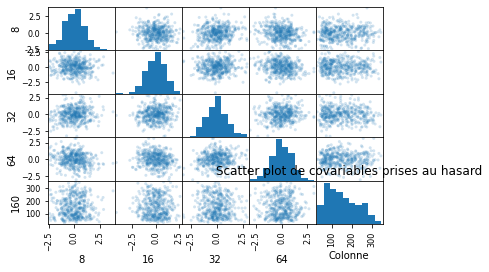

In [5]:
pd.plotting.scatter_matrix(df[[8, 16, 32, 64, 160]], alpha=0.2)
plt.xlabel("Colonne")
plt.ylabel("Colonne")
plt.title("Scatter plot de covariables prises au hasard")

### 3.

In [6]:
# Séparation entre variables explicative et variable à expliquer
X, y = df.drop(columns = 160) , df.iloc[:, 160]

# Création des échantillons de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Affichage des tailles
print('Taille de X_train : ' , X_train.shape)
print('Taille de X_test : ' , X_test.shape)

Taille de X_train :  (331, 160)
Taille de X_test :  (111, 160)


### 4.

*Donner la matrice de covariance calculée sur Xtrain*

In [7]:
n = len(X_train)
G = 1 / n * X_train.T@X_train

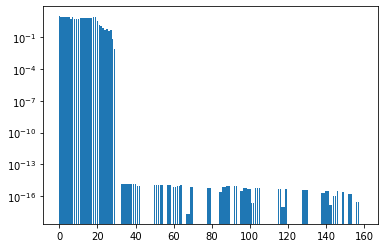

In [517]:
w, v = np.linalg.eig(G)

# Affichage
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.bar([i for i in range(len(w))], w.real);

*Expliquer pourquoi il est légitime de ne garder que les premières variables de l’ACP.*

**Réponse** : les premières variables de l'ACP sont celles qui ont le plus de poids. En gardant seulement les premières variables on se restreint aux plus importantes. Dans notre cas on sait qu'il y a beaucoup de variables inutiles, on cherche donc à ne considérer que celles qui ont un pouvoir prédictif.

### 5.

R² PCA before OLS :  -0.08627837057860477


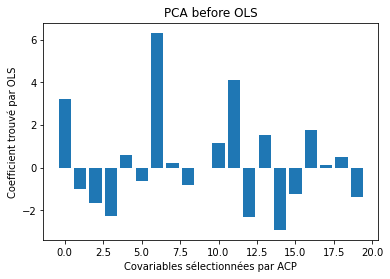

In [9]:
# Régression PCA before OLS
reg_PCAbeforeOLS = LinearRegression(fit_intercept=True).fit(X_train@(v[:, :20].real), y_train)

# Affichage
plt.bar([i for i in range(len(reg_PCAbeforeOLS.coef_))], reg_PCAbeforeOLS.coef_)
plt.xlabel("Covariables sélectionnées par ACP")
plt.ylabel("Coefficient trouvé par OLS")
plt.title("PCA before OLS")

R² OLS :  0.4356611057803975


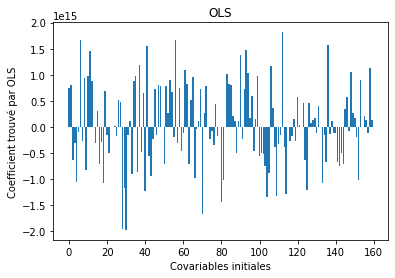

In [10]:
# Régression OLS classique
reg_OLS = LinearRegression(fit_intercept=True).fit(X_train, y_train)

# Affichage
plt.bar([i for i in range(len(reg_OLS.coef_))], reg_OLS.coef_)
plt.xlabel("Covariables initiales")
plt.ylabel("Coefficient trouvé par OLS")
plt.title("OLS")

### 6.

In [145]:
# comparaison des intercepts et de la valeur moyenne de Y
print('Comparaison des intercepts et de la valeur moyenne de Y')
print('reg_PCAbeforeOLS : ', reg_PCAbeforeOLS.intercept_)
print('reg_OLS : ', reg_OLS.intercept_)
print('y_train : ', y_train.mean())

Comparaison des intercepts et de la valeur moyenne de Y
reg_PCAbeforeOLS :  155.1711967336441
reg_OLS :  154.25575906344412
y_train :  155.28700906344412


*Commenter*

**Réponse** : Les intercepts sont proches mais ne sont ni égaux entre eux ni à la valeur moyenne observée sur le jeu d'entraînement

In [148]:
# centrer réduire
A = X_train@(v[:, :20].real)
X_train_cr = (A - A.mean())/A.std()

# vérification de la valeur de l'intercept
reg = LinearRegression(fit_intercept=True).fit(X_train_cr, y_train)
reg.intercept_
print('Comparaison de l\' intercept PCA before OLS centré réduit et de la valeur moyenne de Y')
print('reg_PCAbeforeOLS version centrée réduite : ', reg.intercept_, '\ny_train : ', y_train.mean())

Comparaison de l' intercept PCA before OLS centré réduit et de la valeur moyenne de Y
reg_PCAbeforeOLS version centrée réduite :  155.28700906344412 
y_train :  155.28700906344412


Cette fois l'intercept est égal à la valeur moyenne de y sur le jeu d'entraînement. En effet les opérations de centrage et réduction ont corrigé les perturbations introduites par la séparation du jeu de données en jeu d'entraînement et de test.

### 7.

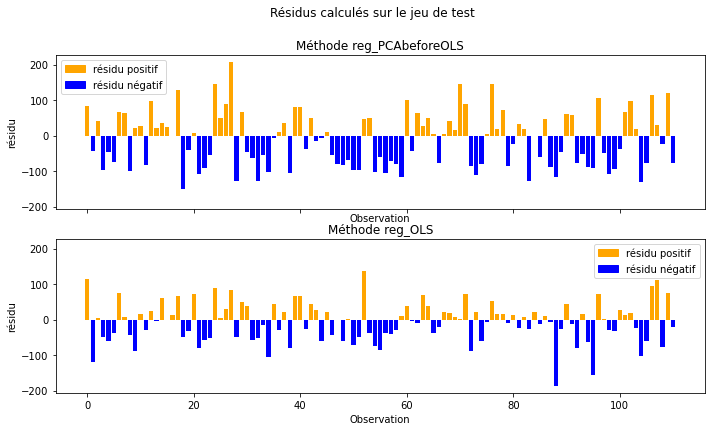

In [200]:
r_PCAbeforeOLS = y_test - reg_PCAbeforeOLS.predict(X_test@(v[:, :20].real))
r_OLS = y_test - reg_OLS.predict(X_test)

# Affichage
def plot_residu(r, methode_name, i):
    colors = {'résidu positif':'orange', 'résidu négatif':'blue'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax[i].legend(handles, labels)
    ax[i].set_xlabel("Observation")
    ax[i].set_ylabel("résidu")
    ax[i].set_title("Méthode {}".format(methode_name))
    ax[i].bar([i for i in range(len(r))], height = r, color=['orange' if x > 0 else 'blue' for x in r])


fig, ax = plt.subplots(2,1, sharex=True, sharey =True)
fig.set_size_inches(10,6)
fig.suptitle('Résidus calculés sur le jeu de test')
fig.tight_layout(pad=2)


plot_residu(r_PCAbeforeOLS, 'reg_PCAbeforeOLS', 0)    
plot_residu(r_OLS, 'reg_OLS', 1)

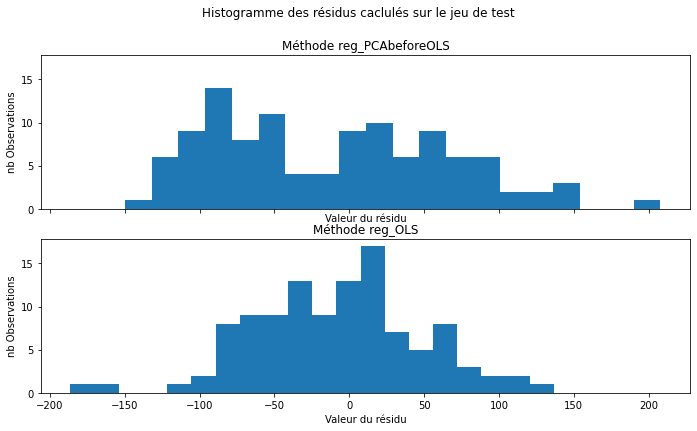

In [213]:
# Affichage
def plot_density(r, methode_name, i):
    ax[i].set_xlabel("Valeur du résidu")
    ax[i].set_ylabel("nb Observations")
    ax[i].set_title("Méthode {}".format(methode_name))
    ax[i].hist(r, bins = 20)


fig, ax = plt.subplots(2,1, sharex=True, sharey =True)
fig.set_size_inches(10,6)
fig.suptitle('Histogramme des résidus caclulés sur le jeu de test')
fig.tight_layout(pad=2)


plot_density(r_PCAbeforeOLS, 'reg_PCAbeforeOLS', 0)    
plot_density(r_OLS, 'reg_OLS', 1)

In [205]:
# Coefficient de détermination
print("R² OLS : ", reg_OLS.score(X_test, y_test))
print("R² PCA before OLS : ", reg_PCAbeforeOLS.score(X_test@(v[:, :20].real), y_test))

R² OLS :  0.4356611057803975
R² PCA before OLS :  -0.08627837057860477


In [217]:
n = len(y_test)
print('Risque de prédiction pour PCA before OLS : ', (r_PCAbeforeOLS ** 2).sum() / n )
print('Risque de prédiction pour OLS classique : ',(r_OLS ** 2).sum() / n )

Risque de prédiction pour PCA before OLS :  6197.559566380407
Risque de prédiction pour OLS classique :  3219.7307865830803


### 8. 

In [295]:
def find_next_variable(X_train, sv, sc, y_train):
    n = len(y_train)
    pvalue_min = 1
    remaining_variables = [x for x in X_train.columns if x not in sv]

    for k in remaining_variables:
        reg = LinearRegression(fit_intercept=True).fit(np.array(X_train[k]).reshape(-1, 1), y_train)
        sigma = X_train[k].std()
        T = np.sqrt(n) * reg.coef_[0] / (sigma * np.linalg.inv(G)[k,k])
        pvalue = 2*t.cdf(-abs(T), n - np.linalg.matrix_rank(X))
        if pvalue < pvalue_min:
            pvalue_min = pvalue
            selected_variable = k
            selected_coefficient = reg.coef_
            
    return selected_variable, selected_coefficient[0]

def forward_vs_iter(X_train, sv, sc, y_train):
    y = y_train
    for var, coef in list(zip(sv, sc)):
        y = y - X_train[var] * coef
    v, c = find_next_variable(X_train, sv, sc, y)
    
    sv_res = sv.copy()
    sc_res = sc.copy()
    sv_res.append(v)
    sc_res.append(c)
    
    return sv_res, sc_res

In [317]:
sv, sc = [], []
for i in range(10):
    sv, sc = forward_vs_iter(X_train, sv, sc, y_train)
print('Variables sélectionnées par forward : ', sv)
print('Nombre de variables retrouvées : ', sum([x in [22, 82, 23, 132, 154, 79, 115, 73, 122, 13] for x in sv]), '/10')

Variables séléctionnées par forward :  [13, 23, 132, 82, 22, 122, 115, 73, 79, 154]
Nombre de variables retrouvées :  10 /10


### 9.

In [320]:
# Régression OLS
reg = LinearRegression(fit_intercept=True).fit(X_train[sv], y_train)
residus = y_test - reg.predict(X_test[sv])
print('Risque de prédiction : ', (residus ** 2).sum() / len(y_test) )

Risque de prédiction :  3003.126732488954


Le risque de prédiction est le meilleur obtenu jusqu'à présent ce qui est logique car on a retrouvé toutes les bonnes variables.

#### BONUS
En modifiant 2 variables, on obtient toujours un risque inférieur à la régression OLS simple et PCA before OLS :

In [327]:
# Falsification de 2 variables dans les variables sélectionnées
sv_corrompu = sv.copy()
sv_corrompu[2], sv_corrompu[9] = (55, 56)

# Régression OLS classique
reg = LinearRegression(fit_intercept=True).fit(X_train[sv_corrompu], y_train)
residus = y_test - reg.predict(X_test[sv_corrompu])
print('Risque de prédiction en falsifiant 2 variables séléctionnées: ', (residus ** 2).sum() / len(y_test) )

Risque de prédiction en falsifiant 2 variables séléctionnées:  3197.805159778865


### 10.

In [355]:
folds = KFold(n_splits = 5 , shuffle = True).split(X_train, y_train)
i = 0
for i, fold in enumerate(folds):
    x, y = fold
    print("N° échantillons sélectionnés pour le Fold ", i, '\n', y, '\n')

N° échantillons sélectionnés pour le Fold  0 
 [  4   5   8  14  15  30  40  44  45  49  60  65  68  72  73  81  92  97
  98 110 115 118 122 131 135 139 141 143 147 151 153 154 157 161 169 174
 181 183 184 187 199 203 213 214 215 220 227 228 239 243 250 253 258 263
 274 292 296 298 301 305 307 308 310 314 320 322 323] 

N° échantillons sélectionnés pour le Fold  1 
 [  2  11  13  17  20  34  48  56  57  58  62  66  74  76  79  80  82  85
  86  88  96 101 116 121 128 129 133 144 150 155 159 160 168 173 176 178
 185 191 195 196 198 202 209 217 218 230 231 238 245 246 251 255 259 268
 269 272 273 281 282 294 299 303 309 324 327 330] 

N° échantillons sélectionnés pour le Fold  2 
 [  0   7  22  27  29  33  37  38  41  42  46  51  52  53  54  63  78  87
  89  91  95 102 103 107 108 109 111 114 119 124 145 146 163 165 166 167
 171 172 175 177 179 180 188 190 193 200 208 210 211 219 226 233 240 262
 265 278 280 284 287 290 291 293 295 306 311 329] 

N° échantillons sélectionnés pour le Fold 

### 11. 

In [419]:
# Application de Ridge
def ridge_cv(X_train, y_train, l_lambda, n_splits):
    d_lambda = {el:[] for el in l_lambda}

    for X, y in KFold(n_splits = n_splits , shuffle = True).split(X_train, y_train):
        for lamb, l_rp in d_lambda.items() :

            # Entraînement de Ridge sur 4 folds
            clf = Ridge(alpha=lamb)
            clf.fit(X_train.iloc[X, :], y_train.iloc[X])

            # Calcul du risque de prédiction sur 1 fold
            residus = y_train.iloc[y] - clf.predict(X_train.iloc[y, :])
            rp =  (residus ** 2).sum() / len(y)
            l_rp.append(rp)
    
    # Passage à la moyenne du risque de prédiction pour chaque lambda
    for k, v in d_lambda.items():
        d_lambda[k] = sum(v) / len(v)
    
    return d_lambda

In [476]:
# Calcul
l_lambda = np.logspace(-10, 2, 400)
res = ridge_cv(X_train, y_train, l_lambda, 5)

Text(0.5, 1.0, 'Optimisation du paramètre de prédiction avec validation croisée')

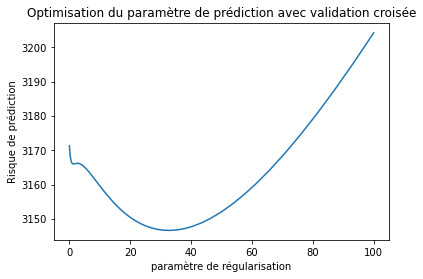

In [477]:
# Affichage
plt.plot(list(res.keys()), list(res.values()))
plt.xlabel("paramètre de régularisation")
plt.ylabel("Risque de prédiction")
plt.title("Optimisation du paramètre de prédiction avec validation croisée")

In [478]:
print('Valeur du paramètre de régularisation optimale pour Ridge : ',list(res.keys())[np.argmin(list(res.values()))])
print('Risque associé : ', min(list(res.values())) )

Valeur du paramètre de régularisation optimale :  33.02151484968176
Risque associé :  3146.638278984461


### 12.

In [504]:
reg_lasso = LassoCV(cv = 5).fit(X_train, y_train)
rp_lasso = ((y_test - reg_lasso.predict(X_test))**2).sum() / len(y_test)
print('Valeur du paramètre de régularisation optimale pour LassoCV: ',reg_lasso.alpha_)
print('Risque associé : ', rp_lasso)

Valeur du paramètre de régularisation optimale pour LassoCV:  3.9012910497271465
Risque associé :  2986.3033649684894


### 13.

In [511]:
sel_var_lasso = []
for i, coef in enumerate(reg_lasso.coef_):
    if coef != 0 :
        sel_var_lasso.append(i)

print("LassoCV a sélectionné ", len(sel_var_lasso), ' variables')
print("Variables sélectionnées  : ", sel_var_lasso)

LassoCV a sélectionné  14  variables
Variables sélectionnées  :  [13, 23, 30, 71, 79, 82, 95, 115, 122, 132, 134, 137, 138, 142]


In [515]:
# Régression OLS sur les variables retrouvées par le lasso
reg = LinearRegression(fit_intercept=True).fit(X_train[sel_var_lasso], y_train)
residus = y_test - reg.predict(X_test[sel_var_lasso])
print('Risque de prédiction : ', (residus ** 2).sum() / len(y_test) )

Risque de prédiction :  3149.3635998460204


### 14.

In [513]:
print('Nombre de variables retrouvées par le Lasso: ', sum([x in [22, 82, 23, 132, 154, 79, 115, 73, 122, 13] for x in sel_var_lasso]), '/10')

Nombre de variables retrouvées par le Lasso:  7 /10
